In [5]:
import pandas as pd
import numpy as np

import quandl
import pandas_datareader.data as web

from scipy.optimize import minimize

from datetime import datetime as dt

from utils.plotting import plot_series

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Portfolio optimisation

We'll use Monte Carlo simulation to distinguish which portfolio allocation gives the best Sharpe ratio.

## Define helper funcs

In [6]:
# Define periods
def periods(start, end):
    start = start.split('-')
    end   = end.split('-')
    return dt(int(start[0]), int(start[1]), int(start[2])), dt(int(end[0]), int(end[1]), int(end[2]))

In [7]:
def sharpe_ratio(daily_return, k = 1, no_risk_return = 0):
    return k**.5 * ((daily_return.mean() - no_risk_return) / daily_return.std())

## Get the data

In [8]:
start, end = periods('2017-01-01', '2020-01-01')

In [20]:
aapl = web.DataReader('AAPL', 'stooq', start, end).sort_index().Close
csco = web.DataReader('CSCO', 'stooq', start, end).sort_index().Close
amzn = web.DataReader('AMZN', 'stooq', start, end).sort_index().Close
ibm  = web.DataReader('IBM', 'stooq', start, end).sort_index().Close

## Build a portfolio

In [21]:
stock_df = pd.DataFrame({'AAPL': aapl, 'CSCO': csco, 'AMZN': amzn, 'IBM': ibm})

In [22]:
stock_df.head()

,AAPL,CSCO,AMZN,IBM
Date,,,,
2015-01-13,101.290,24.001,294.74,128.57
2015-01-14,100.900,23.846,293.27,127.74
2015-01-15,98.145,23.410,286.95,126.73
2015-01-16,97.374,23.641,290.74,128.81
2015-01-20,99.880,23.973,289.44,128.67


## Examine the relations between daily rets

In [23]:
# Mean daily returns
stock_df.pct_change(1).mean()

AAPL    0.001013
CSCO    0.000638
AMZN    0.001644
IBM     0.000132
dtype: float64

In [24]:
# Correlations between daily returns
stock_df.pct_change(1).corr()

,AAPL,CSCO,AMZN,IBM
AAPL,1.000000,0.508655,0.490597,0.396051
CSCO,0.508655,1.000000,0.443307,0.493352
AMZN,0.490597,0.443307,1.000000,0.330986
IBM,0.396051,0.493352,0.330986,1.000000


## Log returns

In [25]:
# Compute log returns
log_rets = np.log(stock_df / stock_df.shift(1))

In [26]:
log_rets.head()

,AAPL,CSCO,AMZN,IBM
Date,,,,
2015-01-13,NaN,NaN,NaN,NaN
2015-01-14,-0.003858,-0.006479,-0.005000,-0.006477
2015-01-15,-0.027684,-0.018453,-0.021786,-0.007938
2015-01-16,-0.007887,0.009819,0.013121,0.016280
2015-01-20,0.025410,0.013946,-0.004481,-0.001087


In [27]:
# Compute `regular` arithmetic returns
reg_rets = stock_df.pct_change(1)

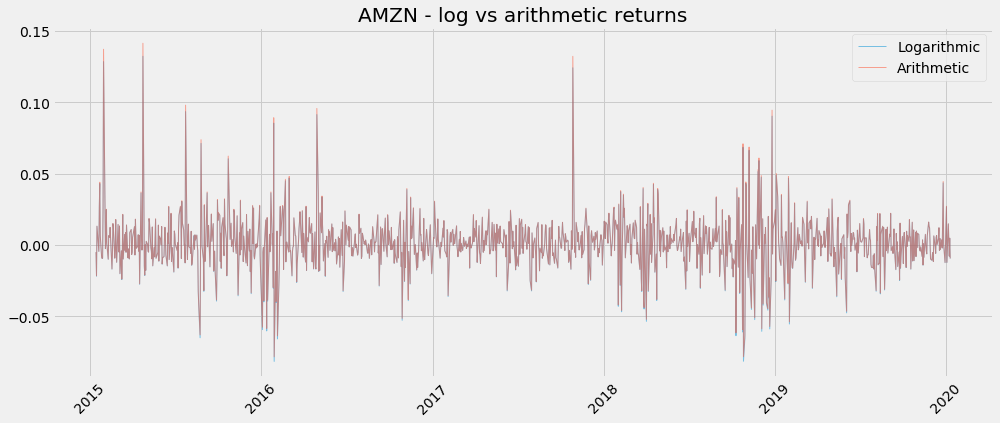

In [28]:
# Plot both
plot_series([log_rets.AMZN, reg_rets.AMZN], ['Logarithmic', 'Arithmetic'], 
            'AMZN - log vs arithmetic returns', lw = 1, alpha = .5)

In this case both returns are almost identical, but it can be crucial for more complex methods.

## Further examine returns

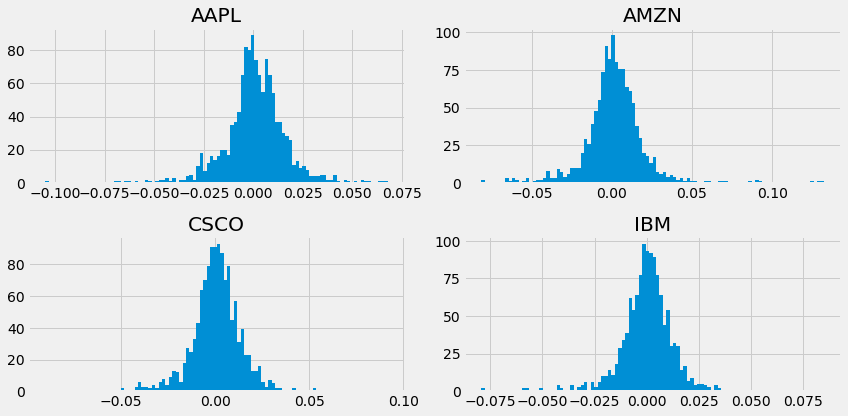

In [31]:
# Plot histograms
log_rets.hist(bins = 100, figsize = (12,6))
plt.tight_layout()
plt.show()

In [33]:
log_rets.mean() * 252

AAPL    0.224464
CSCO    0.135285
AMZN    0.371808
IBM     0.012278
dtype: float64

In [32]:
# Check covariances
log_rets.cov() 

,AAPL,CSCO,AMZN,IBM
AAPL,0.000244,0.000113,0.000141,0.000080
CSCO,0.000113,0.000202,0.000116,0.000091
AMZN,0.000141,0.000116,0.000333,0.000079
IBM,0.000080,0.000091,0.000079,0.000168


## Monte Carlo Sharpe Ratio optimisation

In [148]:
def get_optimal_sr(data, k = 252):

    # Create Random Weights
    weights = np.random.random(data.shape[1])

    # Rebalance Weights
    weights = weights / weights.sum()

    # Expected Return
    ret = np.sum(data.mean() * weights * k)

    # Expected Variance
    vol = np.sqrt(np.dot(weights.T, np.dot(data.cov() * k, weights)))

    # Sharpe Ratio
    return weights, ret, vol, ret / vol

In [149]:
# Run Monte Carlo
n_samples = 15000

mc_results = []

for i in range(n_samples):
    mc_results.append(get_optimal_sr(log_rets))

In [152]:
mc_df = pd.DataFrame(mc_results, columns = ['weights', 'exp_ret', 'exp_vol', 'sharpe_ratio'])

In [153]:
mc_df.head()

,weights,exp_ret,exp_vol,sharpe_ratio
0,"[0.06486469962837414, 0.0714753042580311, 0.21...",0.113567,0.183673,0.618312
1,"[0.29659853797228525, 0.06214100155035718, 0.3...",0.200728,0.191516,1.048102
2,"[0.29598053224486426, 0.04220344582044671, 0.4...",0.226504,0.200149,1.131679
3,"[0.1859363578849683, 0.2171359953735704, 0.222...",0.158399,0.180421,0.877943
4,"[0.30834409732481394, 0.18186649440153183, 0.2...",0.189398,0.186862,1.013575


In [154]:
# Get the best ratio
mc_df.iloc[mc_df.sharpe_ratio.idxmax(), :]

weights         [0.2522536179078533, 0.012041489020561985, 0.7...
exp_ret                                                  0.328653
exp_vol                                                  0.249611
sharpe_ratio                                              1.31666
Name: 13233, dtype: object

In [155]:
optimal_mc_wiegths = mc_df.iloc[mc_df.sharpe_ratio.idxmax(), :].weights
optimal_mc_wiegths_norm = optimal_mc_wiegths / optimal_mc_wiegths.sum()

optimal_idx = mc_df.iloc[mc_df.sharpe_ratio.idxmax(), :].name

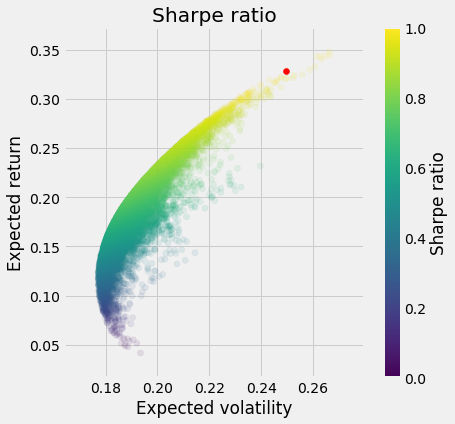

In [156]:
# Plot it
plt.figure(figsize = (6, 6))
plt.scatter(mc_df.exp_vol, mc_df.exp_ret, alpha = .1, c = mc_df.sharpe_ratio)
plt.scatter(mc_df.iloc[optimal_idx, :].exp_vol, mc_df.iloc[optimal_idx, :].exp_ret, color = 'red')
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.title('Sharpe ratio')
plt.show()

## Optimizer-based Sharpe Ratio optimisation

In [64]:
# Optimizer helper function
def get_ret_vol_sr(weights, k = 252):
    weights = np.array(weights)
    ret = np.sum(log_rets.mean() * weights * k)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_rets.cov() * k, weights)))
    sharpe_ratio = ret / vol
    return np.array([ret, vol, sharpe_ratio])

In [65]:
def neg_sharpe(weights):
    return -get_ret_vol_sr(weights)[2]

In [66]:
# Define constrains
def check_sum(weights):
    return np.sum(weights) - 1

In [67]:
constraints = ({'type': 'eq', 'fun': check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
init_weights = [.25] * 4

In [68]:
# Run optimizer
opt_results = minimize(neg_sharpe, 
                       init_weights, 
                       method = 'SLSQP',
                       bounds = bounds,
                       constraints = constraints)

In [69]:
opt_results

     fun: -1.321005356527864
     jac: array([-2.74285674e-04,  7.16823041e-02,  1.03533268e-04,  3.71558294e-01])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.73997090e-01, 0.00000000e+00, 7.26002910e-01, 4.25007252e-17])

Text(0.5, 1.0, 'Optimal portfolio allocations')

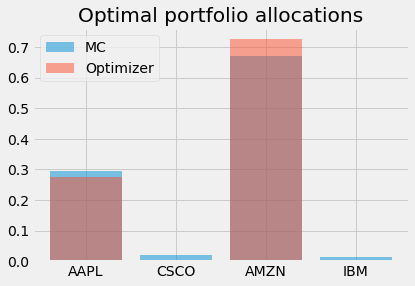

In [70]:
# Get allocations
plt.bar(log_rets.columns, 
        height = optimal_mc_wiegths_norm,
        alpha  = .5, 
        label  = 'MC')

plt.bar(log_rets.columns, 
        height = opt_results.x, 
        alpha  = .5, 
        label  = 'Optimizer')

plt.legend()
plt.title('Optimal portfolio allocations')

## Find efficient frontier

Find max return for a given level of risk or the lowest risk possible for a given return level.

In [171]:
# Get the return space
frontier_y = np.linspace(0, .35, 100)

In [172]:
def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

In [173]:
frontier_volatility = []

for i, possible_return in zip(range(len(frontier_y)), frontier_y):
    
    print(f'Loop {i}')
    
    constraints = (
        {'type': 'eq', 'fun': check_sum}, 
                   # For some weights
        {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_vol, 
                      init_weights,
                      method      = 'SLSQP',
                      bounds      = bounds,
                      constraints = constraints)
    
    frontier_volatility.append(result['fun'])

Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Loop 10
Loop 11
Loop 12
Loop 13
Loop 14
Loop 15
Loop 16
Loop 17
Loop 18
Loop 19
Loop 20
Loop 21
Loop 22
Loop 23
Loop 24
Loop 25
Loop 26
Loop 27
Loop 28
Loop 29
Loop 30
Loop 31
Loop 32
Loop 33
Loop 34
Loop 35
Loop 36
Loop 37
Loop 38
Loop 39
Loop 40
Loop 41
Loop 42
Loop 43
Loop 44
Loop 45
Loop 46
Loop 47
Loop 48
Loop 49
Loop 50
Loop 51
Loop 52
Loop 53
Loop 54
Loop 55
Loop 56
Loop 57
Loop 58
Loop 59
Loop 60
Loop 61
Loop 62
Loop 63
Loop 64
Loop 65
Loop 66
Loop 67
Loop 68
Loop 69
Loop 70
Loop 71
Loop 72
Loop 73
Loop 74
Loop 75
Loop 76
Loop 77
Loop 78
Loop 79
Loop 80
Loop 81
Loop 82
Loop 83
Loop 84
Loop 85
Loop 86
Loop 87
Loop 88
Loop 89
Loop 90
Loop 91
Loop 92
Loop 93
Loop 94
Loop 95
Loop 96
Loop 97
Loop 98
Loop 99


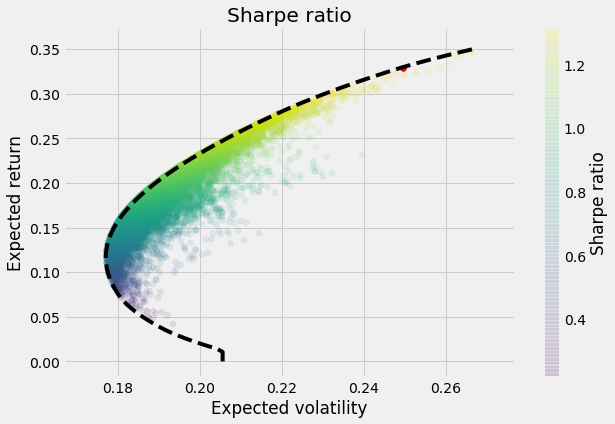

In [176]:
# Plot it
plt.figure(figsize = (9, 6))
plt.scatter(mc_df.exp_vol, mc_df.exp_ret, alpha = .1, c = mc_df.sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.title('Sharpe ratio')
# Add frontier volatility to the plot
plt.plot(frontier_volatility, frontier_y, '--', color = 'black')
plt.scatter(mc_df.iloc[optimal_idx, :].exp_vol, mc_df.iloc[optimal_idx, :].exp_ret, color = 'red')
plt.show()